# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt

2024-06-01 14:30:52.650193: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 14:30:52.650542: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 14:30:52.653463: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 14:30:52.690600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 14:30:53.258766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

In [2]:
# Provide the names for the feature columns since the CSV file with the data 
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.

In [3]:
car_data = car_data_init[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']]
print('Data types pre-processing:')
print(car_data.dtypes)

# Convert all columnns to numeric and set missing to NaN
car_data = car_data.apply(pd.to_numeric, errors='coerce')
print('\nData types post-processing:')
print(car_data.dtypes)


Data types pre-processing:
horsepower     object
peak-rpm       object
city-mpg        int64
highway-mpg     int64
price          object
dtype: object

Data types post-processing:
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [4]:
print('Shape of car_data:', car_data.shape)

# Remove the missing values
car_data.dropna(inplace=True)

print('Shape of car_data:', car_data.shape)


Shape of car_data: (205, 5)
Shape of car_data: (199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [5]:
np.random.seed(0)

# Create list of indices
indices = car_data.index.values.tolist()
print('Indices list:', indices)

# Shuffle the indices list
shuffled_indices = np.random.permutation(indices)
print('\nShuffled indices:', shuffled_indices)

# Reindex car_data using the shuffled indices
car_data = car_data.reindex(shuffled_indices)
car_data.head()

Indices list: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204]

Shuffled indices: [ 19 175 109  95 182 189   5 145  13 166  64 127 170 151  83   7  34 135
  38

,horsepower,peak-rpm,city-mpg,highway-mpg,price
19,70.0,5400.0,38,43,6295.0
175,92.0,4200.0,27,32,9988.0
109,97.0,5000.0,19,24,12440.0
95,69.0,5200.0,31,37,7799.0
182,52.0,4800.0,37,46,7775.0


### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [6]:
# Set prices to Y
Y = car_data['price']
print('Shape of Y:', Y.shape)

# Set remaining fields to X
X = car_data[['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']]
print('Shape of X:', X.shape)

Shape of Y: (199,)
Shape of X: (199, 4)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice. You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [7]:
# Split data into train, val, and test
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1234)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=1234)

print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of Y_val:', Y_val.shape)
print('Shape of Y_test:', Y_test.shape)


Shape of X_train: (119, 4)
Shape of X_val: (40, 4)
Shape of X_test: (40, 4)
Shape of Y_train: (119,)
Shape of Y_val: (40,)
Shape of Y_test: (40,)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [8]:
print('Quantiles for X_train:')
print(X_train.quantile([0.25, 0.5, 0.75, 0.95]))

# Values are not uniformly scaled across features. The 'peak-rpm' feature
# is measured in the 1000s while the others are in the 10s and 100s

# Get mean and standard deviation for X-train
X_train_col_means = np.mean(X_train, axis=0)
X_train_col_stddev = np.std(X_train, axis=0)

# Standardize features in all X sets
X_train_std = ((X_train - X_train_col_means) / X_train_col_stddev)
X_val_std = ((X_val - X_train_col_means) / X_train_col_stddev)
X_test_std = ((X_test - X_train_col_means) / X_train_col_stddev)

# We use the mean and standard deviation from the training set because that is the distribution
# we are assuming for the whole population and therefore that is the distribution used
# when creating the regression coefficients. The distribution in the validation and test could 
# be skewed in any way, and this would shift the line that we have fit our model to.

# Get mean and standard deviation for Y_train
Y_train_col_means = np.mean(Y_train, axis=0)
Y_train_col_stddev = np.std(Y_train, axis=0)

# Standardize features in all X sets
Y_train_std = ((Y_train - Y_train_col_means) / Y_train_col_stddev)
Y_val_std = ((Y_val - Y_train_col_means) / Y_train_col_stddev)
Y_test_std = ((Y_test - Y_train_col_means) / Y_train_col_stddev)


Quantiles for X_train:
      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      21.0         25.0
0.50        90.0    5100.0      25.0         30.0
0.75       116.0    5400.0      31.0         37.0
0.95       176.6    5810.0      37.0         42.1


---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

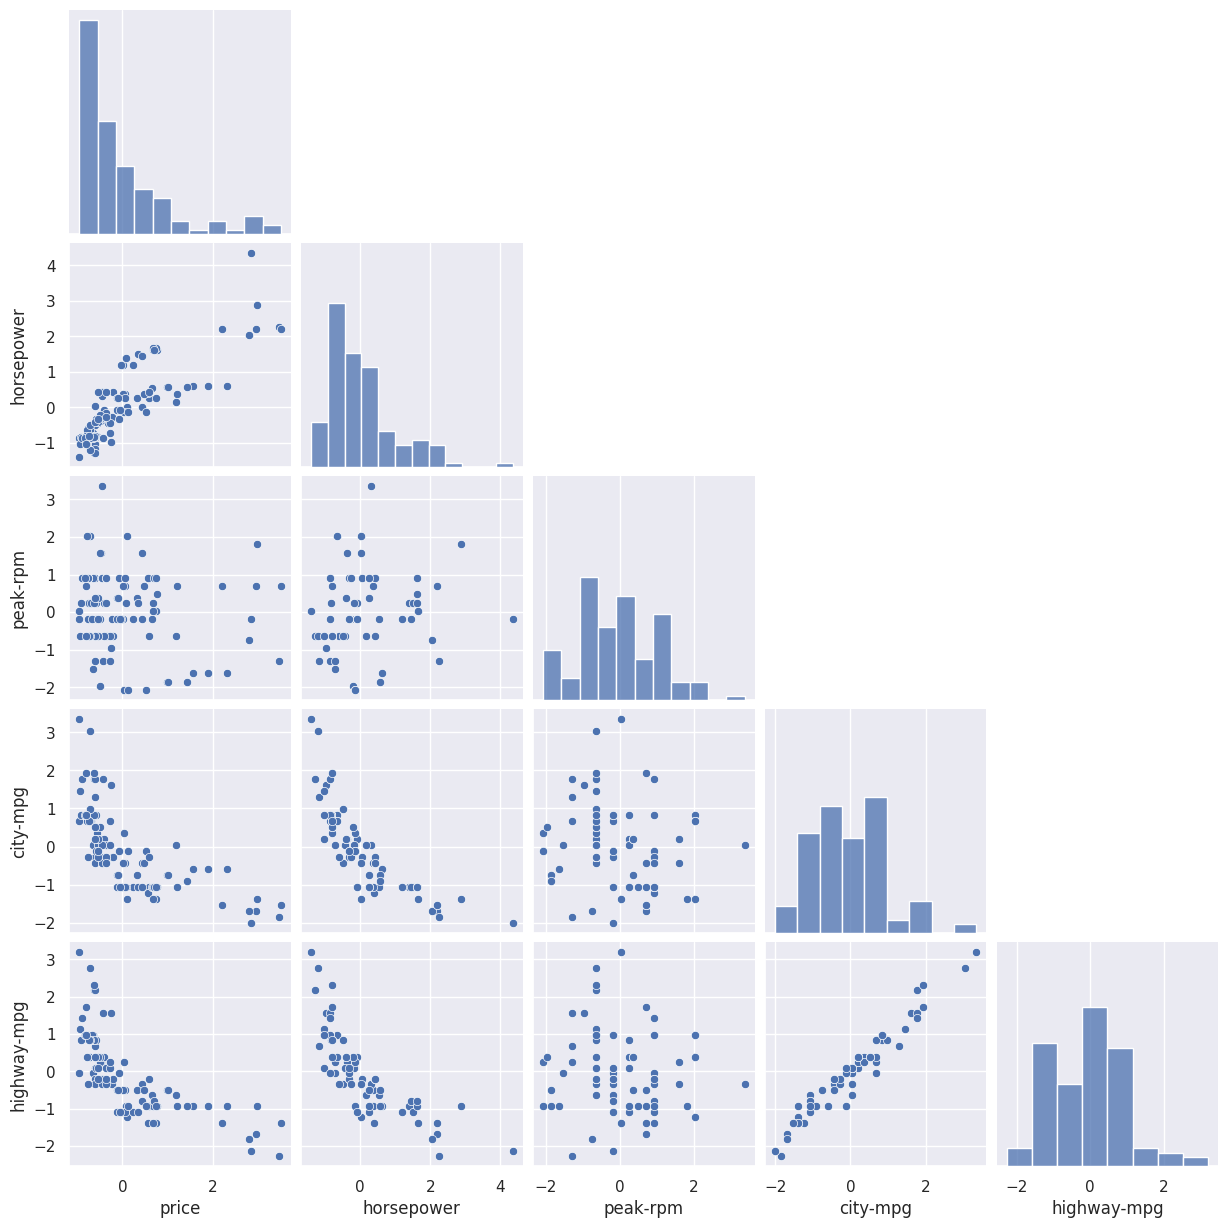

In [9]:
# join the X and Y sets to plot
all_train_std = pd.concat((Y_train_std, X_train_std), axis=1) 
sns.pairplot(all_train_std, corner=True)

# Though the current data set distributions do not reflect a exact normal shape, horsepower, peak-rpm, 
# and the mpg features show some normal shape. Be that as it may, normality is not necessary for a 
# linear regression model. The model assumes that there is some linear relationship between the outcome
# and target variables and that the residuals are normally distributed. 

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

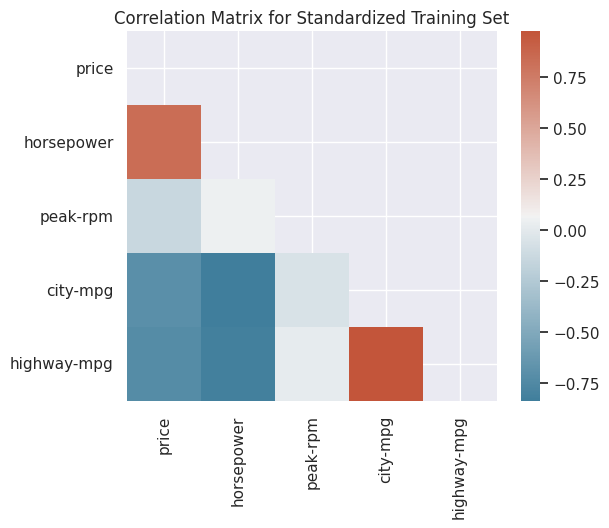

In [10]:
# Compute the correlation matrix
corr = all_train_std.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots()
ax.set_title('Correlation Matrix for Standardized Training Set')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)

plt.show()

# city-mpg and highway-mpg are going to be the most redundant as they have
# an almost perfect correlation with each other

# peak-rpm isn going to be the least helpful feature as it has a very
# low correlation with price

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [11]:
# Revert Y_train_std back to original price and find mean
Y_train_mean = (Y_train_std * Y_train_col_stddev + Y_train_col_means).mean()
print('Mean of Y train:', Y_train_mean)


Mean of Y train: 12889.008403361344


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [12]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  # We specify the loss and the optimizer above
  model.compile(
      optimizer=optimizer,
      loss='mse',
  )
    
  return model

Epoch 1/5


/home/jcisneros/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5379 - val_loss: 6.4812
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5217 - val_loss: 6.4622
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5055 - val_loss: 6.4434
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4894 - val_loss: 6.4245
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4734 - val_loss: 6.4058


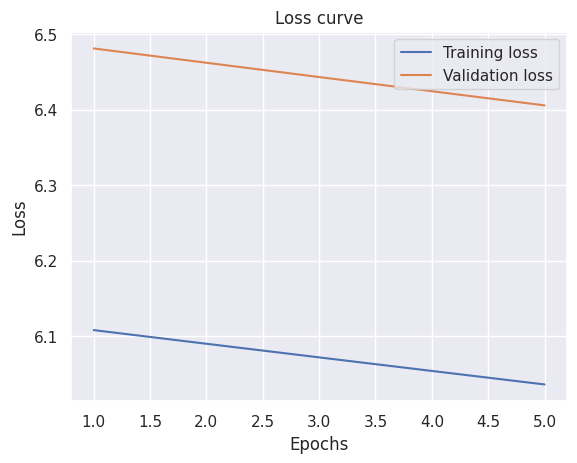

In [13]:
tf.random.set_seed(0)
# 2. Build and compile model
learning_rate = 0.0001
epochs = 5

model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=learning_rate)

# 3. Fit the model
model_fit = model_tf.fit(
    x=X_train_std,
    y=Y_train_std,
    epochs=epochs,
    validation_data=(X_val_std, Y_val_std)
)

# Plot the loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_axis = range(1, epochs+1)
plt.plot(epochs_axis, train_loss, label='Training loss')
plt.plot(epochs_axis, val_loss, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the model (this should include the bias term). Hint: use  <span style="color:chocolate">model_tf.layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch loss that is below 0.35.

/home/jcisneros/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model parameters: [array([[ 1.0880693 ],
       [-0.17551102],
       [ 0.20982309],
       [ 0.01883988]], dtype=float32), array([0.01949536], dtype=float32)]
Final loss amount for training: 0.3015
Final loss amount for validation: 0.3022
Percent difference in traning and validation losses: 0.24%


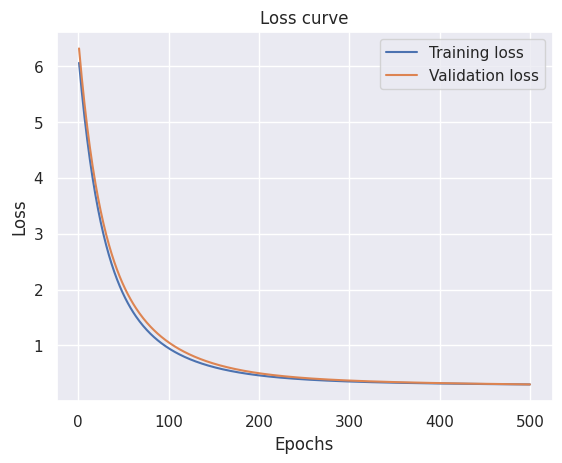

In [14]:
tf.random.set_seed(0)
# Build and compile model
learning_rate = 0.001
epochs = 500

model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=learning_rate)

# Fit the model
model_fit = model_tf.fit(
    x=X_train_std,
    y=Y_train_std,
    epochs=epochs,
    validation_data=(X_val_std, Y_val_std),
    verbose=0
)

# Print model configuration
train_final_loss = model_fit.history['loss'][epochs-1]
val_final_loss = model_fit.history['val_loss'][epochs-1]
print('Model parameters:', model_tf.layers[0].get_weights())
print(f'Final loss amount for training: {train_final_loss:.4f}')
print(f'Final loss amount for validation: {val_final_loss:.4f}')
print(f'Percent difference in traning and validation losses: {(val_final_loss - train_final_loss) / train_final_loss * 100:.2f}%')

# Plot the loss
train_loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs_axis = range(1, epochs+1)

plt.plot(epochs_axis, train_loss, label='Training loss')
plt.plot(epochs_axis, val_loss, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

1. MSE
MSE for train data: 0.3013
MSE for test data: 0.4702
--------------------------------------------------
2. Generalization Capabilities:
The model is relatively good at generalizing for prices on the lower end of the 
scale, but as the price of the car increases, the errors increase. We can see
from our scatterplot matrix above, that this phenomenom occurs when graphing
the relationship between horsepower and price. At the higher end of the values
the relationship is much weaker than at the lower end. This suggests that there
are other factors that we are not considering for higher priced cars.



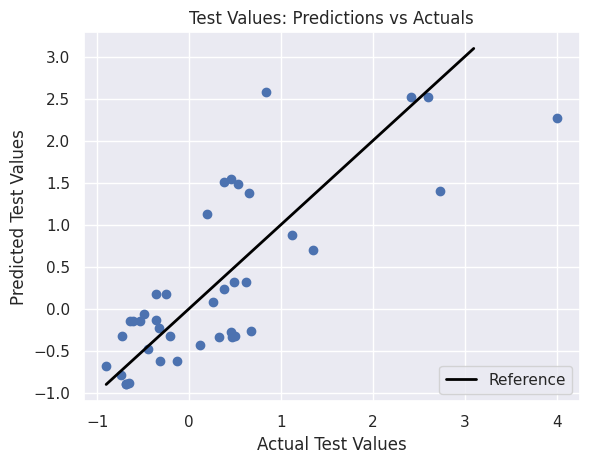

In [19]:
# evaluate model on train and test data sets
train_eval = model_tf.evaluate(
    x=X_train_std,
    y=Y_train_std,
    verbose=0
)

test_eval = model_tf.evaluate(
    x=X_test_std,
    y=Y_test_std,
    verbose=0
)

print('1. MSE')
print(f'MSE for train data: {train_eval:.4f}')
print(f'MSE for test data: {test_eval:.4f}')

print('-'*50)
print(f'''2. Generalization Capabilities:
The model is relatively good at generalizing for prices on the lower end of the 
scale, but as the price of the car increases, the errors increase. We can see
from our scatterplot matrix above, that this phenomenom occurs when graphing
the relationship between horsepower and price. At the higher end of the values
the relationship is much weaker than at the lower end. This suggests that there
are other factors that we are not considering for higher priced cars.
''')

# get predictions for test data
Y_test_predict = model_tf.predict(X_test_std, verbose=0)

# graph the actual vs predicted values
ref_line = np.arange(Y_test_std.min(), Y_test_std.max())
plt.scatter(
    x=Y_test_std,
    y=Y_test_predict
)
plt.plot(ref_line, ref_line, color='black', lw=2, label='Reference')
plt.title('Test Values: Predictions vs Actuals')
plt.xlabel('Actual Test Values')
plt.ylabel('Predicted Test Values')
plt.legend(loc='lower right')
plt.show()


----
### <span style="color:chocolate">Bonus question</span> (20 points)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Conducting a subgroup model evaluation. More precisely, compute the test data MSE based on various car subgroups such as make, engine size, fuel type, etc.

2. Answering the question: is the model "fair" to your chosen car subgroups in our data?

In [16]:
# Set the list of columns for the subgroups
cols = ['make', 'engine-size', 'fuel-type', 'body-style', 'symboling', 'engine-type']

# Get the indices for the records in the Test and get the full Init df
test_indices = X_test_std.index.values.tolist()
test_full_data = car_data_init.loc[test_indices]

# Loop through the columns and get the MSE by subgroup
for col in cols:
    print('-'*50)
    print(f'Evaluating subgroups in column: {col}')
    # Get a list of the unique values in column - these are the subgroups
    subgroups = test_full_data[col].unique().tolist()

    # loop through the subgroups
    for subgroup in subgroups:
        # get the indices for the subgroup
        subgroup_indices = test_full_data.loc[test_full_data[col] == subgroup].index.values.tolist()
        # get the records for subgroup within the test std data
        X_test_subgroup_std = X_test_std.loc[subgroup_indices]
        Y_test_subgroup_std = Y_test_std.loc[subgroup_indices]

        subgroup_eval = model_tf.evaluate(
            x=X_test_subgroup_std,
            y=Y_test_subgroup_std,
            verbose=0
        )

        print(f'\tNumber of records in {subgroup} = {len(subgroup_indices)}; MSE = {subgroup_eval:.4f}')

# There are a few subgroups that have better performance in the model. For example, for the 'body-style'
# the sedans and wagons perform better than the hardtops and convertibles. This makes intuitive
# sense as the hardtops and convertibles are likely sports cars that have higher horsepower and are
# on the higher end of the price spectrum. In general, it is difficult to state confidently if the
# subgroups are being treated fairly, as there are only a few records per subgroup

--------------------------------------------------
Evaluating subgroups in column: make
	Number of records in honda = 3; MSE = 0.0587
	Number of records in volkswagen = 2; MSE = 0.1766
	Number of records in plymouth = 3; MSE = 0.1056
	Number of records in peugot = 5; MSE = 0.3571
	Number of records in saab = 2; MSE = 0.2800
	Number of records in bmw = 1; MSE = 0.6830
	Number of records in mazda = 3; MSE = 0.3781
	Number of records in porsche = 3; MSE = 0.0260
	Number of records in toyota = 5; MSE = 0.5860
	Number of records in volvo = 1; MSE = 0.0209
	Number of records in dodge = 1; MSE = 0.1491
	Number of records in subaru = 2; MSE = 0.0055
	Number of records in audi = 1; MSE = 0.4207
	Number of records in nissan = 3; MSE = 1.3798
	Number of records in mitsubishi = 3; MSE = 0.4209
	Number of records in mercedes-benz = 2; MSE = 2.3946
--------------------------------------------------
Evaluating subgroups in column: engine-size
	Number of records in 110 = 1; MSE = 0.0930
	Number of rec